In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize":(15,6)})
pd.pandas.set_option("display.max_columns",None)

## Modal Training

In [69]:
df = pd.read_csv('data/finalTrain.csv')
df_copy = df.copy()

In [70]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45584 entries, 0 to 45583
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45584 non-null  object 
 1   Delivery_person_ID           45584 non-null  object 
 2   Delivery_person_Age          43730 non-null  float64
 3   Delivery_person_Ratings      43676 non-null  float64
 4   Restaurant_latitude          45584 non-null  float64
 5   Restaurant_longitude         45584 non-null  float64
 6   Delivery_location_latitude   45584 non-null  float64
 7   Delivery_location_longitude  45584 non-null  float64
 8   Order_Date                   45584 non-null  object 
 9   Time_Orderd                  43853 non-null  object 
 10  Time_Order_picked            45584 non-null  object 
 11  Weather_conditions           44968 non-null  object 
 12  Road_traffic_density         44983 non-null  object 
 13  Vehicle_conditio

In [71]:
df_copy.drop(columns=['Delivery_person_ID','ID','Order_Date'],axis=1,inplace=True)

In [72]:
def drop_null(df_copy,column):
          df_copy = df_copy.dropna(subset=[column])
          df_copy = df_copy.reset_index(drop=True)
          return df_copy

df_copy = drop_null(df_copy,'Time_Orderd')
df_copy = drop_null(df_copy,'Time_Order_picked')

In [73]:
def drop_nonformat_time(df_copy,column):
          list1 = []

          for i in range(len(df_copy[column])):
                    if '.' in df_copy[column][i] :
                              list1.append(i)
                    elif len(df_copy[column][i]) <= 2:
                              list1.append(i)

          df_copy.drop(list1,axis=0,inplace=True)
          df_copy = df_copy.reset_index(drop=True)
          
          return df_copy

df_copy = drop_nonformat_time(df_copy,'Time_Orderd')
df_copy = drop_nonformat_time(df_copy,'Time_Order_picked')

In [74]:
import numpy as np
from datetime import datetime

def convert_into_datetime(df_copy,column):
          arr = df_copy[column].values

          drop_values = []

          # Convert the objects to datetime objects
          arr_datetime = []
          for obj in arr:
                    if len(obj) == 5:
                              obj += ':00'
                    try:
                              arr_datetime.append(datetime.strptime(obj, '%H:%M:%S'))
                    except:
                              drop_values.append(obj)
                              continue
          
          df_copy = df_copy.drop(df_copy[df_copy[column].isin(drop_values)].index)

          # Convert the datetime objects to the desired format
          arr_strftime = [obj.strftime('%H:%M:%S') for obj in arr_datetime]

          # Replace the original column with the new column
          df_copy[column] = arr_strftime
          
          return df_copy

df_copy = convert_into_datetime(df_copy,'Time_Orderd')
df_copy = convert_into_datetime(df_copy,'Time_Order_picked')

In [75]:
import numpy as np
from datetime import datetime

def count_diff(df_copy,column1,column2,column3):
          df_copy[column1] = pd.to_datetime(df_copy[column1], format='%H:%M:%S')
          df_copy[column2] = pd.to_datetime(df_copy[column2], format='%H:%M:%S')

          df_copy[column3] = (df_copy[column2] - df_copy[column1]).dt.total_seconds() / 60
          
          df_copy[column3] = df_copy[column3].astype(np.int64)
          
          return df_copy

df_copy = count_diff(df_copy,'Time_Orderd','Time_Order_picked','Time_diff')

In [76]:
df_copy.drop(columns=['Time_Orderd','Time_Order_picked'],axis=1,inplace=True)

In [78]:
## Independent and dependent features
X = df_copy.drop(labels=['Time_taken (min)'],axis=1)
Y = df_copy[['Time_taken (min)']]

In [79]:
X.isnull().sum()

Delivery_person_Age            173
Delivery_person_Ratings        213
Restaurant_latitude              0
Restaurant_longitude             0
Delivery_location_latitude       0
Delivery_location_longitude      0
Weather_conditions               0
Road_traffic_density             0
Vehicle_condition                0
Type_of_order                    0
Type_of_vehicle                  0
multiple_deliveries            763
Festival                       175
City                           920
Time_diff                        0
dtype: int64

In [80]:
numerical_columns = X.columns[X.dtypes!='object']
categorical_columns = X.columns[X.dtypes=='object']

In [81]:
# Define the custom ranking for each ordinal variable
Weather_conditions_categories = ['Sunny', 'Cloudy', 'Windy','Fog','Stormy','Sandstorms']
Road_traffic_density_categories = ['Low','Medium','High','Jam']
Type_of_order_categories = ['Drinks', 'Snack', 'Meal','Buffet']
Type_of_vehicle_categories = ['electric_scooter', 'scooter', 'motorcycle']
Festival_categories = ['No', 'Yes']
City_categories = ['Semi-Urban','Urban','Metropolitian']

In [82]:
from sklearn.impute import SimpleImputer ## HAndling Missing Values
from sklearn.preprocessing import StandardScaler # HAndling Feature Scaling
from sklearn.preprocessing import OrdinalEncoder # Ordinal Encoding
## pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [83]:
## Numerical Pipeline
num_pipeline=Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
    ]

)

# Categorigal Pipeline
cat_pipeline=Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('ordinalencoder',OrdinalEncoder(categories=[Weather_conditions_categories,Road_traffic_density_categories,Type_of_order_categories,Type_of_vehicle_categories,Festival_categories,City_categories])),
    ('scaler',StandardScaler())
    ]
)

preprocessor=ColumnTransformer([
('num_pipeline',num_pipeline,numerical_columns),
('cat_pipeline',cat_pipeline,categorical_columns)
])


In [84]:
## Train test split

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.40,random_state=30)

In [85]:
X_train=pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.get_feature_names_out())
X_test=pd.DataFrame(preprocessor.transform(X_test),columns=preprocessor.get_feature_names_out())

In [86]:
## Model Training

from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [49]:
regression=LinearRegression()
regression.fit(X_train,y_train)

LinearRegression()

In [87]:
regression.coef_

array([[ 2.20285522e+00, -2.21203735e+00,  1.10211978e-01,
        -1.02186641e+03, -1.46753474e-01,  1.02195225e+03,
        -1.90550242e+00,  1.92503330e+00,  4.56115304e-02,
         6.08431658e-01,  2.84069713e+00,  3.82916543e-02,
         1.47843782e-02,  1.51751798e+00,  6.87539783e-01]])

In [88]:
regression.intercept_

array([26.36720957])

In [89]:
import numpy as np
def evaluate_model(true, predicted,X_train,y_train):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    n = len(y_train)
    k = len(X_train.columns)
    adjusted_r2_score = 1 - ((1 - r2_square) * (n - 1) / (n - k - 1))
    return mae, rmse, r2_square,adjusted_r2_score

In [96]:
## Train multiple models

models={
    'LinearRegression':LinearRegression(),
    'Lasso':Lasso(),
    'Ridge':Ridge(),
    'Elasticnet':ElasticNet(),
    "RandomForestRegressor":RandomForestRegressor(random_state=3)
}
trained_model_list=[]
model_list=[]
r2_list=[]
y_pred_list = []

print(len(list(models)),'len(list(models)')
for i in range(len(list(models))):
    model=list(models.values())[i]
    model.fit(X_train,y_train)

    #Make Predictions
    y_pred=model.predict(X_test)

    mae, rmse, r2_square,adjusted_r2_score=evaluate_model(y_test,y_pred,X_train,y_train)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    # print(model_list,'model_list')

    print('Model Training Performance')
    print("RMSE:",rmse)
    print("MAE:",mae)
    print("R2 score",r2_square*100)
    print("Adjusted R2 score",adjusted_r2_score*100)

    r2_list.append(r2_square)
    y_pred_list.append(y_pred)
    
    print('='*35)
    print('\n')


5 len(list(models)
LinearRegression
Model Training Performance
RMSE: 6.437778294214285
MAE: 5.100122088616955
R2 score 53.32507092027178
Adjusted R2 score 53.29208976631492


Lasso
Model Training Performance
RMSE: 7.060202803348748
MAE: 5.628758803876964
R2 score 43.863415332809744
Adjusted R2 score 43.82374844143948


Ridge
Model Training Performance
RMSE: 6.6504853788560965
MAE: 5.25485909130347
R2 score 50.18979602489229
Adjusted R2 score 50.15459944209473


Elasticnet
Model Training Performance
RMSE: 7.160329979748693
MAE: 5.7236357273019784
R2 score 42.2598765385202
Adjusted R2 score 42.219076564338835




C:\Users\Asus\AppData\Local\Temp\ipykernel_30712\4284438485.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


RandomForestRegressor
Model Training Performance
RMSE: 4.897972508705921
MAE: 3.8210499188025135
R2 score 72.98255222900308
Adjusted R2 score 72.96346132469908




In [91]:
train_accuracy = model.score(X_train, y_train)

In [92]:
train_accuracy

0.9620989264252939

Text(0, 0.5, 'Predictions')

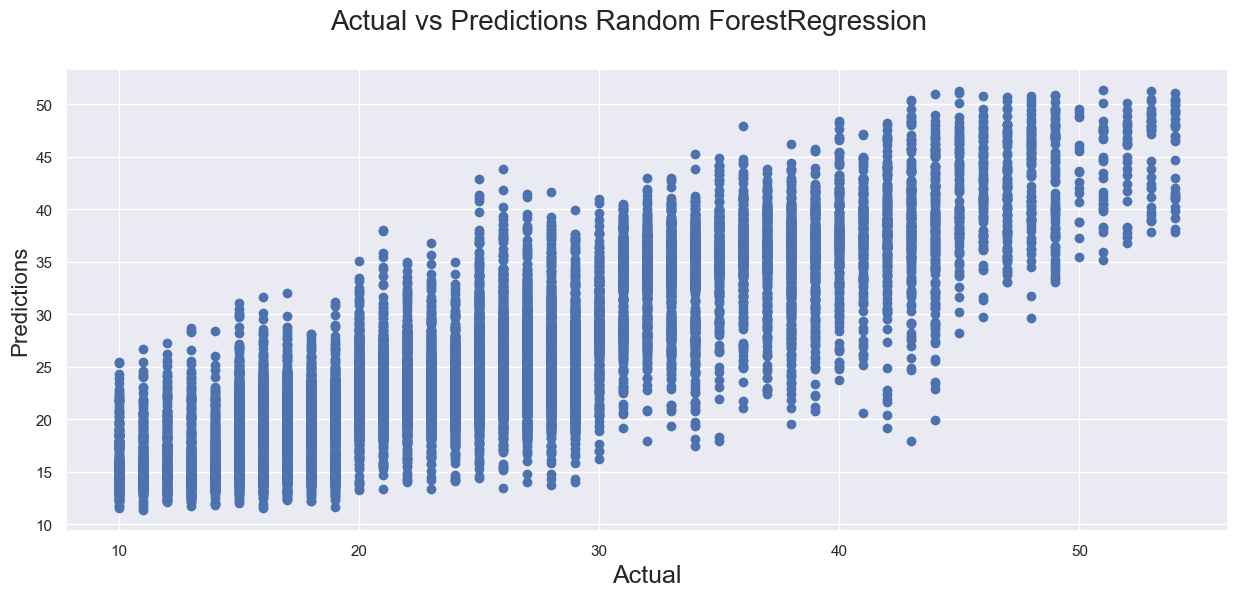

In [100]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred_list[4])
fig.suptitle('Actual vs Predictions Random ForestRegression', fontsize=20)
plt.xlabel('Actual', fontsize=18)                          
plt.ylabel('Predictions', fontsize=16) 